In [ ]:
file_path = 'gold_dec24(GC=F)_1wk.csv'

/var/folders/rx/s42f27kn5j5ddqzlhz7qr2yw0000gn/T/ipykernel_16663/803729589.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'] = df['Close'].fillna(method='ffill').fillna(method='bfill')


Epoch 1/50, Train Loss: 0.1114, Validation Loss: 0.0273, Validation RMSE: 0.1657
Epoch 2/50, Train Loss: 0.0213, Validation Loss: 0.0046, Validation RMSE: 0.0682
Epoch 3/50, Train Loss: 0.0057, Validation Loss: 0.0019, Validation RMSE: 0.0440
Epoch 4/50, Train Loss: 0.0043, Validation Loss: 0.0032, Validation RMSE: 0.0566
Epoch 5/50, Train Loss: 0.0051, Validation Loss: 0.0015, Validation RMSE: 0.0387
Epoch 6/50, Train Loss: 0.0037, Validation Loss: 0.0009, Validation RMSE: 0.0296
Epoch 7/50, Train Loss: 0.0032, Validation Loss: 0.0008, Validation RMSE: 0.0278
Epoch 8/50, Train Loss: 0.0031, Validation Loss: 0.0019, Validation RMSE: 0.0442
Epoch 9/50, Train Loss: 0.0028, Validation Loss: 0.0013, Validation RMSE: 0.0364
Epoch 10/50, Train Loss: 0.0031, Validation Loss: 0.0019, Validation RMSE: 0.0437
Epoch 11/50, Train Loss: 0.0025, Validation Loss: 0.0006, Validation RMSE: 0.0242
Epoch 12/50, Train Loss: 0.0027, Validation Loss: 0.0005, Validation RMSE: 0.0232
Epoch 13/50, Train Loss: 

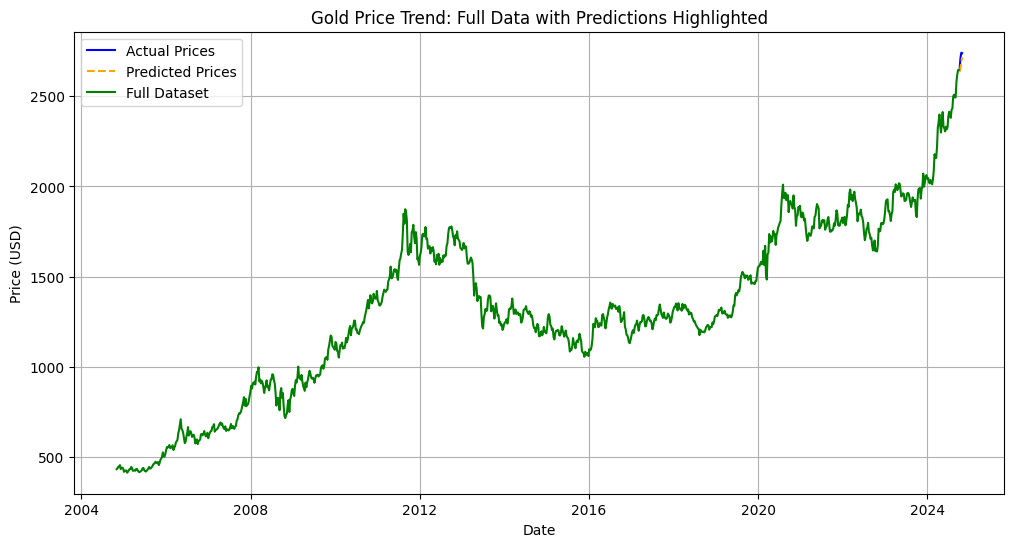

In [40]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import root_mean_squared_error
import torch.nn as nn
import torch.optim as optim

# Load and clean the dataset
file_path = 'gold_dec24(GC=F)_1wk.csv'

df = pd.read_csv(file_path, skiprows=3, names=['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], header=None)

# Parse dates and set as index
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)

# Handle missing values in the 'Close' column
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Close'] = df['Close'].fillna(method='ffill').fillna(method='bfill')

# Normalize the data (both inputs and outputs)
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

# Create sequences for supervised learning
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # Use 12 weeks of data to predict the next value
data = df['Close'].values
X, y = create_sequences(data, seq_length)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Add channel dimension
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split into train/validation and evaluation sets
train_val_size = len(X_tensor) - 4  # Last 4 points for evaluation
train_val_dataset = TensorDataset(X_tensor[:train_val_size], y_tensor[:train_val_size])
eval_dataset = TensorDataset(X_tensor[train_val_size:], y_tensor[train_val_size:])

# Further split train/validation into train and validation sets (80% train, 20% val)
train_size = int(len(train_val_dataset) * 0.8)
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
eval_loader = DataLoader(eval_dataset, batch_size=1)  # Batch size of 1 for evaluation

# Define LSTM Model with Dropout for Regularization
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)  # Dropout layer to prevent overfitting
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden_state, _) = self.lstm(x)
        hidden_state = self.dropout(hidden_state)  # Apply dropout to the hidden state
        output = self.fc(hidden_state[-1])  # Pass through fully connected layer
        return output

model = LSTMModel()

# Define loss function and optimizer with weight decay (L2 regularization)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Training loop with validation and accuracy printing
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    # Training phase
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(X_batch)
        
        # Calculate loss
        loss = criterion(predictions.squeeze(), y_batch)
        
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_actuals = []
    
    with torch.no_grad():
        for X_val, y_val in val_loader:
            val_predictions = model(X_val)
            val_loss += criterion(val_predictions.squeeze(), y_val).item()
            
            # Collect predictions and actuals for RMSE calculation
            val_preds.extend(val_predictions.squeeze().tolist())
            val_actuals.extend(y_val.tolist())
    
    # Calculate RMSE for validation set
    val_rmse = root_mean_squared_error(val_actuals, val_preds)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation RMSE: {val_rmse:.4f}")

# Evaluate on the last 4 points (evaluation set)
model.eval()
eval_preds = []
eval_actuals = []

with torch.no_grad():
    for X_eval, y_eval in eval_loader:
        eval_predictions = model(X_eval)
        eval_preds.append(eval_predictions.item())
        eval_actuals.append(y_eval.item())

# Calculate RMSE for evaluation set (last 4 points)
eval_rmse = root_mean_squared_error(eval_actuals, eval_preds)
print(f"Evaluation RMSE (Last 4 Points): {eval_rmse:.4f}")

# Inverse transform predictions to original scale for better interpretability
eval_preds_scaled = scaler.inverse_transform(np.array(eval_preds).reshape(-1, 1))
eval_actuals_scaled = scaler.inverse_transform(np.array(eval_actuals).reshape(-1, 1))

print("Evaluation Predictions (Scaled):", eval_preds_scaled.flatten())
print("Evaluation Actuals (Scaled):", eval_actuals_scaled.flatten())

# Multi-step prediction loop for future forecasting (autoregressive approach)
last_sequence = X_tensor[-1].unsqueeze(0)  # Start with the last sequence in the dataset
multi_step_preds = []

for _ in range(4):  # Predict next 4 steps iteratively
    with torch.no_grad():
        pred = model(last_sequence).item()
        multi_step_preds.append(pred)
        
    # Update sequence with new prediction (autoregressive step)
    last_sequence = torch.cat((last_sequence[:, 1:, :], torch.tensor([[[pred]]])), dim=1)

# Inverse transform multi-step predictions to original scale
multi_step_preds_scaled = scaler.inverse_transform(np.array(multi_step_preds).reshape(-1, 1))
print("Multi-Step Predictions:", multi_step_preds_scaled.flatten())

# Plot full data with predicted points highlighted (original scale)
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(eval_actuals_scaled):], eval_actuals_scaled.flatten(), label='Actual Prices', color='blue')
plt.plot(df.index[-len(eval_preds_scaled):], eval_preds_scaled.flatten(), label='Predicted Prices', color='orange', linestyle='--')
plt.plot(df.index[:-len(eval_actuals_scaled)], scaler.inverse_transform(df['Close'].values[:-len(eval_actuals_scaled)].reshape(-1, 1)), label='Full Dataset', color='green')
plt.title('Gold Price Trend: Full Data with Predictions Highlighted')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [42]:
n_params = sum(p.numel() for p in model.parameters())  # Total number of parameters in the model
val_loss_total = 0.0

with torch.no_grad():
    for X_val, y_val in val_loader:
        val_predictions = model(X_val)
        val_loss_total += criterion(val_predictions.squeeze(), y_val).item()

# Average validation loss (MSE)
val_loss_avg = val_loss_total / len(val_loader)

# Calculate log-likelihood from MSE (assuming Gaussian errors)
n_data_points = len(val_dataset)
log_likelihood = -n_data_points / 2 * (np.log(2 * np.pi * val_loss_avg) + 1)

# Calculate AIC and BIC
aic = -2 * log_likelihood + 2 * n_params
bic = -2 * log_likelihood + n_params * np.log(n_data_points)

print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

AIC: 20291.8140
BIC: 55737.0231


## ----------------------------------------------------------------------

/var/folders/rx/s42f27kn5j5ddqzlhz7qr2yw0000gn/T/ipykernel_16663/1750657930.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'] = pd.to_numeric(df['Close'], errors='coerce').fillna(method='ffill').fillna(method='bfill')


ADF Statistic: 0.21013250139783682
p-value: 0.9728242032388914
Time series is not stationary. Differencing is required.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8029.333, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8024.809, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8025.560, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8025.560, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8025.646, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8027.403, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.732 seconds
RMSE: 60.2632
MAPE: 2.45%
Ljung-Box Test Statistic: [838.00359712 838.7424819  838.76914554 839.99434926 840.13879165
 840.19528236 842.29202847 842.33719801 842.46246193 842.63849177
 842.7491827  842.93905694 846.3789836  846.38904803 847.07891616
 848.31443838 851.23357917 851.86890098 851.89526689 852.0076016
 853.29582039]
Ljung-Box p-value: [2.94870540e-18

/Users/ytsang/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/ytsang/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/ytsang/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


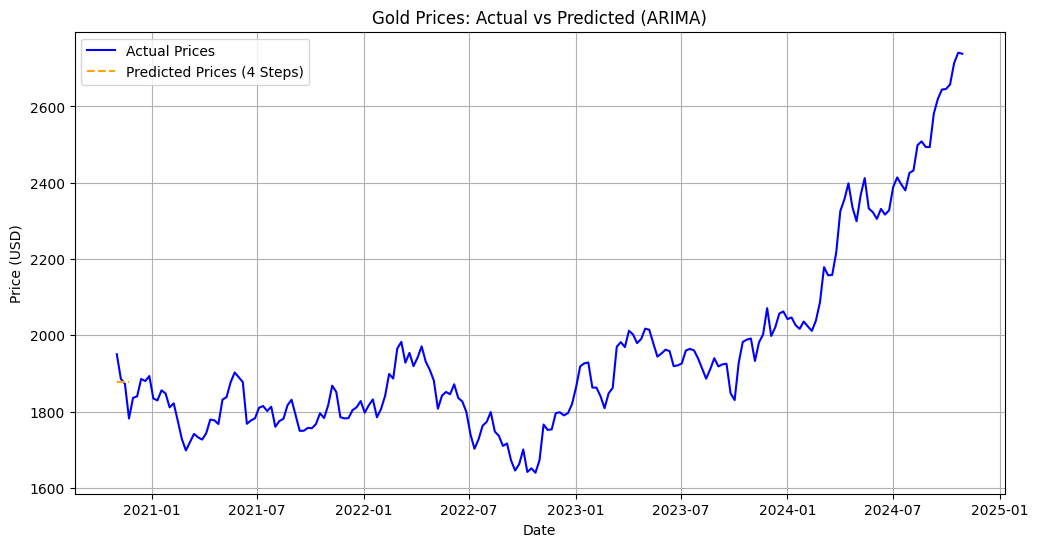

In [60]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf, q_stat
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Load dataset
file_path = 'gold_dec24(GC=F)_1wk.csv'
df = pd.read_csv(file_path, skiprows=3, names=['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], header=None)

# Parse dates and set index
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)

# Handle missing values in 'Close'
df['Close'] = pd.to_numeric(df['Close'], errors='coerce').fillna(method='ffill').fillna(method='bfill')

# Check stationarity using ADF test
result = adfuller(df['Close'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("Time series is not stationary. Differencing is required.")
    df['Close_diff'] = df['Close'].diff().dropna()
else:
    print("Time series is stationary.")

# Split into train/test sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train_data, test_data = df['Close'][:train_size], df['Close'][train_size:]

# Fit ARIMA model with selected parameters (use auto_arima for optimal parameters)
auto_model = auto_arima(train_data, seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True,
                        stepwise=True)
optimal_order = auto_model.order  # Get best (p,d,q)
model = ARIMA(train_data, order=optimal_order)
arima_model = model.fit()

# Multi-step forecasting (4 steps)
forecast_steps = 4
forecast = arima_model.forecast(steps=forecast_steps)

# Evaluate predictions on test data (first 4 points)
mse = mean_squared_error(test_data[:forecast_steps].values, forecast.values)
rmse = np.sqrt(mse)

# Calculate MAPE
mape = np.mean(np.abs((test_data[:forecast_steps].values - forecast.values) / test_data[:forecast_steps].values)) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# Ljung-Box test on residuals
residuals = arima_model.resid
lb_test_statistic, lb_p_value = q_stat(acf(residuals, nlags=20), len(residuals))

print(f"Ljung-Box Test Statistic: {lb_test_statistic}")
print(f"Ljung-Box p-value: {lb_p_value}")

# Plot actual vs predicted values for 4 steps
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data.values, label='Actual Prices', color='blue')
plt.plot(test_data.index[:forecast_steps], forecast.values, label='Predicted Prices (4 Steps)', color='orange', linestyle='--')
plt.title('Gold Prices: Actual vs Predicted (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

## -----------------------------------------------------------------------

/var/folders/rx/s42f27kn5j5ddqzlhz7qr2yw0000gn/T/ipykernel_16663/81425229.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'] = df['Close'].fillna(method='ffill').fillna(method='bfill')


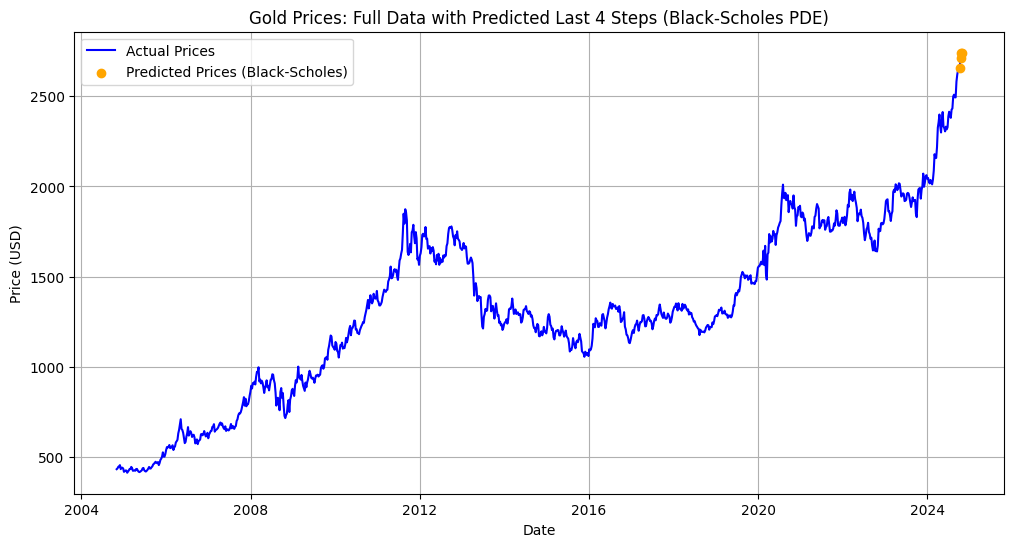

Actual Prices: [2657.60009766 2713.69995117 2740.89990234 2738.30004883]
Predicted Prices: [2657.60009766 2713.69995116 2740.89990234 2738.30004883]


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(file_path, skiprows=3, names=['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], header=None)

# Parse dates and set as index
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)

# Handle missing values in the 'Close' column
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Close'] = df['Close'].fillna(method='ffill').fillna(method='bfill')

# Extract gold prices
gold_prices = df['Close'].values

# Exclude the last 4 data points for evaluation
train_prices = gold_prices[:-4]  # Use all but the last 4 points for training
test_prices = gold_prices[-4:]   # Use the last 4 points for evaluation

# Define Black-Scholes parameters
sigma = 0.2  # Volatility (assume 20%)
r = 0.01     # Risk-free rate (assume 1%)
T = 4        # Time horizon (4 steps)
dt = 1       # Time step (1 step per week)
S_max = max(train_prices) * 2  # Maximum price for grid
N = len(train_prices)          # Number of price points in training data

# Create grids for price and time
dS = S_max / N
S_grid = np.linspace(0, S_max, N)
t_grid = np.linspace(0, T, int(T/dt) + 1)

# Initialize option value grid (V)
V = np.zeros((len(t_grid), len(S_grid)))

# Set initial condition: V(S, T) = S (final prices)
V[-1, :] = S_grid

# Solve Black-Scholes PDE using finite difference method (implicit scheme)
for t in range(len(t_grid) - 2, -1, -1):
    for i in range(1, len(S_grid) - 1):
        delta_S = S_grid[i + 1] - S_grid[i]
        gamma_S = (S_grid[i + 1] - 2 * S_grid[i] + S_grid[i - 1]) / delta_S**2

        # Black-Scholes PDE finite difference scheme
        V[t, i] = (
            V[t + 1, i]
            + dt * (
                r * S_grid[i] * (V[t + 1, i + 1] - V[t + 1, i - 1]) / (2 * delta_S)
                + sigma**2 * S_grid[i]**2 * gamma_S / 2
                - r * V[t + 1, i]
            )
        )

# Extract predicted prices from the grid at t=0
predicted_prices = V[0, :]

# Map predicted prices to actual gold prices grid for evaluation points
predicted_prices_mapped = np.interp(test_prices, S_grid, predicted_prices)

# Plot full dataset with predicted last 4 steps highlighted
plt.figure(figsize=(12, 6))
plt.plot(df.index, gold_prices, label='Actual Prices', color='blue')
plt.scatter(df.index[-4:], predicted_prices_mapped, label='Predicted Prices (Black-Scholes)', color='orange', zorder=5)
plt.title('Gold Prices: Full Data with Predicted Last 4 Steps (Black-Scholes PDE)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Print results
print("Actual Prices:", test_prices)
print("Predicted Prices:", predicted_prices_mapped)


## --------------------------------------------------------------------------------